In [84]:
#import dependencies
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import pandas as pd
import numpy as np
import matplotlib .pyplot as plt
%matplotlib inline
import quandl
from config import api

#scaling data
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier


In [79]:
# File to Load - import all Confidence Indexs
CCI_data_to_load = "startdata/CCI_Raw_data.csv"
BCI_data_to_load = 'startdata/BCI_Raw_data.csv'
CLI_data_to_load = 'startdata/CLI_Raw_data.csv'
# Read School and Student Data File and store into Pandas DataFrames
CCI_data = pd.read_csv(CCI_data_to_load)
BCI_data = pd.read_csv(BCI_data_to_load)
CLI_data = pd.read_csv(CLI_data_to_load)
CLI_data.head()

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
0,GBR,CLI,AMPLITUD,LTRENDIDX,M,1957-12,97.69984,NaN
1,GBR,CLI,AMPLITUD,LTRENDIDX,M,1958-01,97.73627,NaN
2,GBR,CLI,AMPLITUD,LTRENDIDX,M,1958-02,97.84341,NaN
3,GBR,CLI,AMPLITUD,LTRENDIDX,M,1958-03,97.99134,NaN
4,GBR,CLI,AMPLITUD,LTRENDIDX,M,1958-04,98.15497,NaN


In [82]:
#clean CI (confidence index) data

#remove unnecessary columns
filtered_CCI = CCI_data[['TIME','Value']]
filtered_BCI = BCI_data[['TIME','Value']]
filtered_CLI = CLI_data[['TIME','Value']]

#convert dates to datetime
import datetime
filtered_CCI['TIME']= pd.to_datetime(filtered_CCI['TIME'])
filtered_BCI['TIME']= pd.to_datetime(filtered_BCI['TIME'])
filtered_CLI['TIME']= pd.to_datetime(filtered_CLI['TIME'])

#rename columns
CCI_df= filtered_CCI.rename(columns={"TIME": "date", "Value": "value"})
CLI_df= filtered_CLI.rename(columns={"TIME": "date", "Value": "value"})
BCI_df= filtered_BCI.rename(columns={"TIME": "date", "Value": "value"})

#further filter data for uniform dates in all 3 datasets
CCI_df = CCI_df[CCI_df['date'] > '2007-12-31']
BCI_df = BCI_df[BCI_df['date'] > '2007-12-31']
CLI_df = CLI_df[CLI_df['date'] > '2007-12-31']

,TIME,Value
0,1973-01,101.2458
1,1973-02,101.2283
2,1973-03,101.0854
3,1973-04,100.8459
4,1973-05,100.7044


In [86]:
#for loop function to add filler dates in information to match ticker dates day for day
def date_gen(df):
    
    #create range of days:
    dates = pd.date_range(start ='01/01/2008',end ='11/16/2020')
    
    #create empty dataframe and counter variable
    sample = pd.DataFrame({'date': [], 'value': []})
    counter = 0
    
    #for loop to fill in individual dates
    for date in dates:
        if date.month == df.iloc[counter]['date'].month:
            sample = sample.append({'date': date, 'value': df.iloc[counter]['value']},ignore_index=True)
        else:
            counter +=1
            sample = sample.append({'date': date, 'value': df.iloc[counter]['value']},ignore_index=True)
    return sample

In [94]:
#run each set through the for loop function above
BCI_adj = date_gen(BCI_df)
CLI_adj = date_gen(CLI_df)
CCI_adj = date_gen(CCI_df)

#rename value columns to differentatiate values
CCI_adj= CCI_adj.rename(columns={ "value": "CCI"})
CLI_adj= CLI_adj.rename(columns={ "value": "CLI"})
BCI_adj= BCI_adj.rename(columns={"value": "BCI"})

#sanity check
#BCI_adj.head(3)

#merge datasets
BCI_CCI = BCI_adj.merge(CCI_adj,how='inner',on='date')
OECD_data = CLI_adj.merge(BCI_CCI, how='inner',on='date')
OECD_data.head()

,date,CLI,BCI,CCI
0,2008-01-01,100.5212,101.5117,100.1894
1,2008-01-02,100.5212,101.5117,100.1894
2,2008-01-03,100.5212,101.5117,100.1894
3,2008-01-04,100.5212,101.5117,100.1894
4,2008-01-05,100.5212,101.5117,100.1894


In [4]:
#convert to csv
OECD_data.to_csv('startdata/OECD_data_2008_to_2020.csv')
OECD_data

In [47]:
#CPI

#code to run tests on all 30 sample tickers

#define function for tests on CPI/CLI/BCI
def tester_new(ticker_name):
    
    #import API key
    from config import api
    quandl.ApiConfig.api_key = api
    #data = quandl.get_table('WIKI/PRICES', qopts = { 'columns': ['date','ticker','open','high','low','close','volume'] }, ticker = ['AAPL', 'GOOGL','AMZN'], date = { 'gte': '2010-01-01', 'lte': '2020-11-12' })
    #df = quandl.get_table('WIKI/PRICES', ticker = ['AAPL', 'GOOGL','AMZN'], date = { 'gte': '2010-01-01', 'lte': '2020-11-12' })
    stock_data = quandl.get_table('WIKI/PRICES', ticker = [ticker_name], date = { 'gte': '2008-01-01', 'lte': '2018-12-30' })
    
    #load OECD data with stock data
    OECD_data_to_load = 'startdata/OECD_data_2008_to_2020.csv'
    # Read School and Student Data File and store into Pandas DataFrames
    OECD_data = pd.read_csv(OECD_data_to_load)
    
    #create ticker dictionary
    ticker_dict = {"AMZN":"Amazon","AAPL":'Apple',"CSCO":'Cisco',"CMCSA":'Comcast',"INTC":"Intel","MSFT":'Microsoft',"VZ":'Verizon',"V":"Visa","WMT":'Walmart',"GS":'Goldman Sachs',"JPM":"JP Morgan","JNJ":'Johnson & Johnson',"PFE":"Pfeizer","MRK":'Merck',"GIS":'General Mills','PG':'Proctor & Gamble','KO':'Coca Cola','MMM':'3M','MCD':'McDonalds','BA':'Boeing','CAT':'Caterpillar','CVX':'Chevron','XOM':'ExxonMobil','GE':'General Electric',"F":'Ford',"HON":'Honeywell',"HD":'Home Depot'}

    #convert to date
    stock_data['date']= pd.to_datetime(stock_data['date'])
    OECD_data['date']= pd.to_datetime(OECD_data['date'])
    
    from sklearn.neighbors import KNeighborsClassifier
    
    #combine stock dataset with OECD information
    combine = stock_data.merge(OECD_data,how='inner',on='date')
    
    # Sub-Task 1: Define xy and shape so ML algorithm can use data
    X = combine[["BCI","CCI","CLI"]]
    y = combine["adj_close"].values.reshape(-1, 1)
    
    #import dependents
    from sklearn.metrics import mean_squared_error
    from sklearn.linear_model import LinearRegression
    from sklearn.model_selection import train_test_split
    
    #define variables
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    train = combine[:8000]
    test = combine[8000:]
    # Sub-Task 3: Scale data

    from sklearn.preprocessing import StandardScaler
    X_scaler = StandardScaler().fit(X_train)
    y_scaler = StandardScaler().fit(y_train)

    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)
    y_train_scaled = y_scaler.transform(y_train)
    y_test_scaled = y_scaler.transform(y_test)
    
    #create linear regression
    model = LinearRegression()
    model.fit(X_train_scaled, y_train_scaled)
    
    
    # Sub-Task 5: Determine MSE and R2
    #create variables
    predictions = model.predict(X_test_scaled)
    MSE = mean_squared_error(y_test_scaled, predictions)
    r2 = model.score(X_test_scaled, y_test_scaled)
    
    
    # plot data and save as png
    model.fit(X_train_scaled, y_train_scaled)
    plt.scatter(model.predict(X_train_scaled), model.predict(X_train_scaled) - y_train_scaled, c="blue", label="Training Data")
    plt.scatter(model.predict(X_test_scaled), model.predict(X_test_scaled) - y_test_scaled, c="orange", label="Testing Data")
    plt.legend()
    plt.xlabel('Normalized CPI')
    plt.ylabel('Normalized Closing Price')
    plt.hlines(y=0, xmin=y_test_scaled.min(), xmax=y_test_scaled.max())
    plt.title(f"Residual Plot of {ticker_dict[ticker_name]}")
    plt.savefig(f'startdata/{ticker_dict[ticker_name]}_residual_CPI_graph.png')
    
    #store in dataframe
    new_row = {'Ticker Name': [ticker_name], 'MSE': [MSE],'r2':[r2]}
    df = pd.DataFrame(data=new_row)
    return df

In [64]:
#define loop function to run all tickers:  
def run_tickers():
    ticker_list = ["AMZN","AAPL","CSCO","CMCSA","INTC","MSFT","VZ","V","WMT","GS","JPM","JNJ","PFE","MRK","GIS",'PG','KO','MMM','MCD','BA','CAT','CVX','XOM','GE',"F","HON","HD"]
    
    #create blank dataframe
    blank = {'Ticker Name': [], 'MSE': [],'r2':[]}
    output = pd.DataFrame(data=blank)
    
    #for loop to run through the 30 tickers  
    for ticker in ticker_list:
        output = output.append(tester_new(ticker))
        print(f'{ticker} is done running')
    return output

In [22]:
#create final dataframe with ML results
final_df = run_tickers()
final_df.head()

AMZN is done running
AAPL is done running
CSCO is done running
CMCSA is done running
INTC is done running
MSFT is done running
VZ is done running
V is done running
WMT is done running
GS is done running
JPM is done running
JNJ is done running
PFE is done running
MRK is done running
GIS is done running
PG is done running
KO is done running
MMM is done running
MCD is done running
BA is done running
CAT is done running
CVX is done running
XOM is done running
GE is done running
F is done running
HON is done running
HD is done running


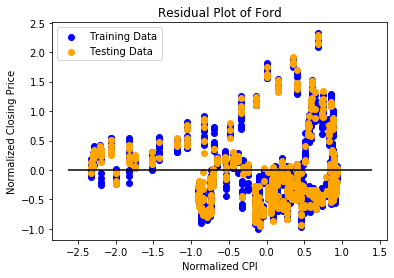

In [51]:
#test plot data
tester_new('F')
plt.show()


In [32]:
#export table results as CSV
final_df.to_csv('f2_MSE_values.csv')

In [48]:
#Volatility

#generate function to generate machine learning for stock volatility 
def volatility_loop(ticker_name):

    # Obtain Raw Data
    # Use Quandl API to obtain data as far back as free access allows
    # Data for stock price data by ticker

    quandl.ApiConfig.api_key = api
    df_ticker = quandl.get_table('WIKI/PRICES', ticker = [ticker_name], date = { 'gte': '1980-01-01', 'lte': '2020-11-12' })

    # Task 1: Delete unwanted columns
    df_ticker.drop(df_ticker.columns[[7,8]], axis=1, inplace=True)
    #df_ticker: create features
    # What is it? This is a measure of the range that the stock price bounces around during a day on the market
    # Why can it be important? If the stock bounces around more, can it close at a higher price more often?
    df_ticker['volatility-calc'] = df_ticker.adj_high - df_ticker.adj_low

    # Feature 2: Introduce Rate of Change Volatility

    # What is it? This is a measure of the change in the range that a stock price bounces around during the market day
    # Why can it be important? If the stock bounce keeps changing, can it close at a higher price more often?
    df_ticker['ROC_Volatility']=df_ticker['volatility-calc'].diff()

    # Feature 3: Introduce 10-Day Simple Moving Average

    # What is it? Quick 10-day lookback at stock closing price. 
    # Why can it be important? Typically traders like to ride a short-term trend for gains. Unofficial rule of 
    # stock trading is..."The trend is your friend" 
    df_ticker['10-Day-SMA']=df_ticker.iloc[:,10].rolling(window=10).mean()

    # Feature 4: Introduce 50-Day Simple Moving Average

    # What is it? Slightly longer 50-day lookback at stock closing price.
    # Why can it be important? Trend it with 10-day lookback using the crossover feature
    df_ticker['50-Day-SMA']=df_ticker.iloc[:,10].rolling(window=50).mean()


    # Feature 5: Introduce crossover to check if 10-day SMA > 50-day SMA

    # What is it? Determining when 10-day stock price avg > 50-day stock price avg
    # Why can it be important? If you buy when 10-day-avg > 50-day-avg, how often does the stock "Breakout"?
    # This is when short-term price spikes yield big gains, one of the most common day-trading patterns on Wall St.

    df_ticker['Crossover']=""

    for index, row in df_ticker.iterrows():
        if (row['10-Day-SMA'] > row['50-Day-SMA']):
            df_ticker.loc[index, 'Crossover']=1
        else:
            df_ticker.loc[index, 'Crossover']=0  

    # Feature 6: Volume
    # What is it? Volume is an inbuilt feature with API data pull and a measure of supply/demand of a certain stock.
    # Why can it be important? How does the supply/demand of a stock change its price?

    # Feature 7: Introduce Rate of Change Volume
    # What is it? A measure of how much the #shares of a stock is changing each day
    # Why can it be important?  Change in volume is a measure of change in supply/demand of the stock, potentially 
    # impacting the stock price.

    df_ticker['ROC_Volume']=df_ticker['adj_volume'].diff()

    # Task 3: Fill NaN values with column means and zeros so ML model can run with usable data
    df_ticker['10-Day-SMA'].fillna(value=df_ticker['10-Day-SMA'].median(), inplace=True)
    df_ticker['50-Day-SMA'].fillna(value=df_ticker['50-Day-SMA'].median(), inplace=True)
    df_ticker['ROC_Volume'] = df_ticker['ROC_Volume'].fillna(0)
    df_ticker['ROC_Volatility'] = df_ticker['ROC_Volatility'].fillna(0)

    #task 4: create model for machine learning
    
    #create ticker dictionary
    ticker_dict = {"AMZN":"Amazon","AAPL":'Apple',"CSCO":'Cisco',"CMCSA":'Comcast',"INTC":"Intel","MSFT":'Microsoft',"VZ":'Verizon',"V":"Visa","WMT":'Walmart',"GS":'Goldman Sachs',"JPM":"JP Morgan","JNJ":'Johnson & Johnson',"PFE":"Pfeizer","MRK":'Merck',"GIS":'General Mills','PG':'Proctor & Gamble','KO':'Coca Cola','MMM':'3M','MCD':'McDonalds','BA':'Boeing','CAT':'Caterpillar','CVX':'Chevron','XOM':'ExxonMobil','GE':'General Electric',"F":'Ford',"HON":'Honeywell',"HD":'Home Depot'}
    
    # Sub-Task 1: Define xy and shape so ML algorithm can use data
    X = df_ticker[["volatility-calc","ROC_Volatility"]]
    y = df_ticker["adj_close"].values.reshape(-1, 1)

    # Sub-Task 2: Define x,y training and testing data

    from sklearn.linear_model import LinearRegression
    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(X, y)
    train = df_ticker[:8000]
    test = df_ticker[8000:]

    # Sub-Task 3: Scale data

    from sklearn.preprocessing import StandardScaler
    X_scaler = StandardScaler().fit(X_train)
    y_scaler = StandardScaler().fit(y_train)

    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)
    y_train_scaled = y_scaler.transform(y_train)
    y_test_scaled = y_scaler.transform(y_test)

    #Sub-Task 4: fit and test data
    from sklearn.linear_model import LinearRegression
    model = LinearRegression()
    model.fit(X_train_scaled, y_train_scaled)

    # Sub-Task 5: Determine MSE and R2 and save as dataframe

    from sklearn.metrics import mean_squared_error

    predictions = model.predict(X_test_scaled)
    MSE = mean_squared_error(y_test_scaled, predictions)
    r2 = model.score(X_test_scaled, y_test_scaled)
    
    # plot data and save as png
    model.fit(X_train_scaled, y_train_scaled)
    plt.scatter(model.predict(X_train_scaled), model.predict(X_train_scaled) - y_train_scaled, c="blue", label="Training Data")
    plt.scatter(model.predict(X_test_scaled), model.predict(X_test_scaled) - y_test_scaled, c="orange", label="Testing Data")
    plt.legend()
    plt.hlines(y=0, xmin=y_test_scaled.min(), xmax=y_test_scaled.max())
    plt.title(f"Residual Plot of {ticker_dict[ticker_name]}")
    plt.xlabel('Normalized Volatility')
    plt.ylabel('Normalized closing price')
    plt.savefig(f'startdata/{ticker_dict[ticker_name]}_residual_Volatility_graph.png')
    
    #store in dataframe
    new_df = {'Ticker Name': [ticker_name], 'MSE': [MSE],'r2':[r2]}
    volatility_df = pd.DataFrame(data=new_df)
    return volatility_df


In [65]:
#loop for all tickers
#define loop function to run all tickers:  
def run_tickers_volatility():
    ticker_list = ["AMZN","AAPL","CSCO","CMCSA","INTC","MSFT","VZ","V","WMT","GS","JPM","JNJ","PFE","MRK","GIS",'PG','KO','MMM','MCD','BA','CAT','CVX','XOM','GE',"F","HON","HD"]
    
    #create blank dataframe
    blank = {'Ticker Name': [], 'MSE': [],'r2':[]}
    output = pd.DataFrame(data=blank)
    
    #for loop to run through the 30 tickers  
    for ticker in ticker_list:
        output = output.append(volatility_loop(ticker))
        print(f'{ticker} is done running')
    return output

In [18]:
#run loop
testv1 = run_tickers_volatility()
testv1.head()

AMZN is done running
AAPL is done running
CSCO is done running
CMCSA is done running
INTC is done running
MSFT is done running
VZ is done running
V is done running
WMT is done running
GS is done running
JPM is done running
JNJ is done running
PFE is done running
MRK is done running
GIS is done running
PG is done running
KO is done running
MMM is done running
MCD is done running
BA is done running
CAT is done running
CVX is done running
XOM is done running
GE is done running
F is done running
HON is done running
HD is done running


,Ticker Name,MSE,r2
0,AMZN,0.555383,0.521779
0,AAPL,0.311349,0.689400
0,CSCO,0.520015,0.482857
0,CMCSA,0.617487,0.432037
0,INTC,0.416126,0.578464


In [ ]:
#export table results as CSV
final_df.to_csv('startdata/vol_MSE_r2_values.csv')

In [42]:
#testing png export
#tester_new('F')

,Ticker Name,MSE,r2
0,AAPL,0.359856,0.677468


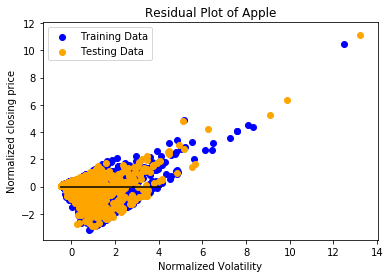

In [50]:
#Testing Volatility png export
volatility_loop('AAPL')

In [68]:
# stock invesment Timing
#pull data from API
quandl.ApiConfig.api_key = api
tdf = quandl.get_table('WIKI/PRICES', paginate=True,ticker = \
                      ["AMZN","AAPL","CSCO","CMCSA","INTC","MSFT","VZ","V","WMT","GS","JPM","JNJ","PFE","MRK","GIS",'PG','KO','MMM','MCD','BA','CAT','CVX','XOM','GE',"F","HON","HD"]
,\
                      date = { 'gte': '2008-01-01', 'lte': '2018-12-30' })

#Extract and create new timing features from 'date'
tdf['year'] = tdf.date.dt.year
tdf['month'] = tdf.date.dt.month
tdf['day'] = tdf.date.dt.day
tdf['day_of_year'] = tdf.date.dt.dayofyear
tdf['week_of_year'] = tdf.date.dt.weekofyear
tdf['day_of_week'] = tdf.date.dt.dayofweek
tdf['day_of_week_name'] = tdf.date.dt.day_name()
tdf['quarter'] = tdf.date.dt.quarter
tdf['mon_fri'] = 0
for index in df.index:
    if tdf.loc[index, 'day_of_week']==0 or tdf.loc[index, 'day_of_week']==4:
        tdf.loc[index,'mon_fri'] = 1
    else:
        tdf.loc[index,'mon_fri'] = 0
df.head()

,ticker,date,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,...,adj_volume,year,month,day,day_of_year,week_of_year,day_of_week,day_of_week_name,quarter,mon_fri
None,,,,,,,,,,,,,,,,,,,,,
0,WMT,2018-03-27,87.96,88.04,85.48,86.05,6395554.0,0.0,1.0,87.96,...,6395554.0,2018,3,27,86,13,1,Tuesday,1,0
1,WMT,2018-03-26,86.22,87.69,86.11,87.50,8640866.0,0.0,1.0,86.22,...,8640866.0,2018,3,26,85,13,0,Monday,1,1
2,WMT,2018-03-23,87.35,87.74,85.28,85.42,9762296.0,0.0,1.0,87.35,...,9762296.0,2018,3,23,82,12,4,Friday,1,1
3,WMT,2018-03-22,87.53,88.27,86.99,87.14,11338049.0,0.0,1.0,87.53,...,11338049.0,2018,3,22,81,12,3,Thursday,1,0
4,WMT,2018-03-21,87.89,89.68,87.68,88.18,11687930.0,0.0,1.0,87.89,...,11687930.0,2018,3,21,80,12,2,Wednesday,1,0


In [59]:
#run data from all 30 companies

#days of the week tester 
def week_tester(ticker_name):
    qquandl.ApiConfig.api_key = api
    #data = quandl.get_table('WIKI/PRICES', qopts = { 'columns': ['date','ticker','open','high','low','close','volume'] }, ticker = ['AAPL', 'GOOGL','AMZN'], date = { 'gte': '2010-01-01', 'lte': '2020-11-12' })
    #df = quandl.get_table('WIKI/PRICES', ticker = ['AAPL', 'GOOGL','AMZN'], date = { 'gte': '2010-01-01', 'lte': '2020-11-12' })
    df = quandl.get_table('WIKI/PRICES', ticker = [ticker_name], date = { 'gte': '2008-01-01', 'lte': '2018-12-30' })
    
    #Extract and create new timing features from 'date' in dataset
    df['year'] = df.date.dt.year
    df['month'] = df.date.dt.month
    df['day'] = df.date.dt.day
    df['day_of_year'] = df.date.dt.dayofyear
    df['week_of_year'] = df.date.dt.weekofyear
    df['day_of_week'] = df.date.dt.dayofweek
    df['day_of_week_name'] = df.date.dt.day_name()
    df['quarter'] = df.date.dt.quarter
    df['mon_fri'] = 0
    for index in df.index:
        if df.loc[index, 'day_of_week']==0 or df.loc[index, 'day_of_week']==4:
            df.loc[index,'mon_fri'] = 1
        else:
            df.loc[index,'mon_fri'] = 0
    
    
   # print(f'Linear Regression model on stock data.  Test correlation closing adjusted price over time')
    #sort the dataset in ascending order
    data = df.sort_index(ascending=True,axis=0)
    #Test model with just 1 feature. Test correlation closing adjusted price over time
    X = data[['day_of_week']].values.reshape(-1,1)
    y = data['adj_close'].values.reshape(-1,1)
    
    #Split the time series train/test data. 70% train, 30% test
    X_train = X[:int(X.shape[0]*0.8)]
    X_test = X[int(X.shape[0]*0.8):]
    y_train = y[:int(y.shape[0]*0.8)]
    y_test = y[int(y.shape[0]*0.8):]

    X_scaler = MinMaxScaler().fit(X_train)
    y_scaler = MinMaxScaler().fit(y_train)

    #transform the training and testing data 
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)
    y_train_scaled = y_scaler.transform(y_train)
    y_test_scaled = y_scaler.transform(y_test)

    # Create a LinearRegression model and fit it to the scaled training data
    model = LinearRegression()
    #train the model using the training data
    model.fit(X_train_scaled, y_train_scaled)

    #Score the model using the unseen testing data
    model.score(X_test_scaled,y_test_scaled)
    #print(f'model score: {model.score(X_test_scaled,y_test_scaled)}')

    # Make predictions using a fitted model
    predictions = model.predict(X_test_scaled)
    model.fit(X_train_scaled, y_train_scaled)

    # Used X_test_scaled, y_test_scaled, and model.predict(X_test_scaled) to calculate MSE and R2
    # A "good" MSE score will be close to zero while a "good" R2 Score will be close to 1.
   
    from sklearn.metrics import mean_squared_error

    MSE = mean_squared_error(y_test_scaled, predictions)
    r2 = model.score(X_test_scaled, y_test_scaled)
    
    #store in dataframe
    data = {'Ticker Name': [ticker_name], 'MSE': [MSE],'r2':[r2]}
    date_df = pd.DataFrame(data=data)
    return date_df

In [ ]:
#volume tester
def volume_tester(ticker_name):
    #import API key
    from config import api
    quandl.ApiConfig.api_key = api
    #data = quandl.get_table('WIKI/PRICES', qopts = { 'columns': ['date','ticker','open','high','low','close','volume'] }, ticker = ['AAPL', 'GOOGL','AMZN'], date = { 'gte': '2010-01-01', 'lte': '2020-11-12' })
    #df = quandl.get_table('WIKI/PRICES', ticker = ['AAPL', 'GOOGL','AMZN'], date = { 'gte': '2010-01-01', 'lte': '2020-11-12' })
    df = quandl.get_table('WIKI/PRICES', ticker = [ticker_name], date = { 'gte': '2008-01-01', 'lte': '2018-12-30' })
    
    #Extract and create new timing features from 'date' in dataset
    df['year'] = df.date.dt.year
    df['month'] = df.date.dt.month
    df['day'] = df.date.dt.day
    df['day_of_year'] = df.date.dt.dayofyear
    df['week_of_year'] = df.date.dt.weekofyear
    df['day_of_week'] = df.date.dt.dayofweek
    df['day_of_week_name'] = df.date.dt.day_name()
    df['quarter'] = df.date.dt.quarter
    df['mon_fri'] = 0
    for index in df.index:
        if df.loc[index, 'day_of_week']==0 or df.loc[index, 'day_of_week']==4:
            df.loc[index,'mon_fri'] = 1
        else:
            df.loc[index,'mon_fri'] = 0
    
    
   # print(f'Linear Regression model on stock data.  Test correlation closing adjusted price over time')
    #sort the dataset in ascending order
    data = df.sort_index(ascending=True,axis=0)
    #Test model with just 1 feature. Test correlation closing adjusted price and volume
    X = data[['volume']].values.reshape(-1,1)
    y = data['adj_close'].values.reshape(-1,1)
    
    #Split the time series train/test data. 70% train, 30% test
    X_train = X[:int(X.shape[0]*0.8)]
    X_test = X[int(X.shape[0]*0.8):]
    y_train = y[:int(y.shape[0]*0.8)]
    y_test = y[int(y.shape[0]*0.8):]

    X_scaler = MinMaxScaler().fit(X_train)
    y_scaler = MinMaxScaler().fit(y_train)

    #transform the training and testing data 
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)
    y_train_scaled = y_scaler.transform(y_train)
    y_test_scaled = y_scaler.transform(y_test)

    # Create a LinearRegression model and fit it to the scaled training data
    model = LinearRegression()
    #train the model using the training data
    model.fit(X_train_scaled, y_train_scaled)

    #Score the model using the unseen testing data
    model.score(X_test_scaled,y_test_scaled)
    #print(f'model score: {model.score(X_test_scaled,y_test_scaled)}')

    # Make predictions using a fitted model
    predictions = model.predict(X_test_scaled)
    model.fit(X_train_scaled, y_train_scaled)

    # Used X_test_scaled, y_test_scaled, and model.predict(X_test_scaled) to calculate MSE and R2
    # A "good" MSE score will be close to zero while a "good" R2 Score will be close to 1.
   
    from sklearn.metrics import mean_squared_error

    MSE = mean_squared_error(y_test_scaled, predictions)
    r2 = model.score(X_test_scaled, y_test_scaled)
    
    #store in dataframe
    data = {'Ticker Name': [ticker_name], 'MSE': [MSE],'r2':[r2]}
    date_df = pd.DataFrame(data=data)
    return date_df

In [57]:
#string item variable tester
def string_tester(ticker_name):
    #import API key
    from config import api
    quandl.ApiConfig.api_key = api
    #data = quandl.get_table('WIKI/PRICES', qopts = { 'columns': ['date','ticker','open','high','low','close','volume'] }, ticker = ['AAPL', 'GOOGL','AMZN'], date = { 'gte': '2010-01-01', 'lte': '2020-11-12' })
    #df = quandl.get_table('WIKI/PRICES', ticker = ['AAPL', 'GOOGL','AMZN'], date = { 'gte': '2010-01-01', 'lte': '2020-11-12' })
    df = quandl.get_table('WIKI/PRICES', ticker = [ticker_name], date = { 'gte': '2008-01-01', 'lte': '2018-12-30' })
    
    #Extract and create new timing features from 'date' in dataset
    df['year'] = df.date.dt.year
    df['month'] = df.date.dt.month
    df['day'] = df.date.dt.day
    df['day_of_year'] = df.date.dt.dayofyear
    df['week_of_year'] = df.date.dt.weekofyear
    df['day_of_week'] = df.date.dt.dayofweek
    df['day_of_week_name'] = df.date.dt.day_name()
    df['quarter'] = df.date.dt.quarter
    df['mon_fri'] = 0
    for index in df.index:
        if df.loc[index, 'day_of_week']==0 or df.loc[index, 'day_of_week']==4:
            df.loc[index,'mon_fri'] = 1
        else:
            df.loc[index,'mon_fri'] = 0
    
    
    #Throw all the features except columns with string values and 'adjusted close'
    data = df.sort_index(ascending=True,axis=0)
    #Test model with just 1 feature. Test correlation closing adjusted price over time
    X = data.drop(['date','ticker','close','adj_close','day_of_week_name'], axis=1)
    y = data['adj_close'].values.reshape(-1,1)
    
    #Split the time series train/test data. 70% train, 30% test
    X_train = X[:int(X.shape[0]*0.8)]
    X_test = X[int(X.shape[0]*0.8):]
    y_train = y[:int(y.shape[0]*0.8)]
    y_test = y[int(y.shape[0]*0.8):]

    X_scaler = MinMaxScaler().fit(X_train)
    y_scaler = MinMaxScaler().fit(y_train)

    #transform the training and testing data 
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)
    y_train_scaled = y_scaler.transform(y_train)
    y_test_scaled = y_scaler.transform(y_test)

    # Create a LinearRegression model and fit it to the scaled training data
    model = LinearRegression()
    #train the model using the training data
    model.fit(X_train_scaled, y_train_scaled)

    #Score the model using the unseen testing data
    model.score(X_test_scaled,y_test_scaled)
    #print(f'model score: {model.score(X_test_scaled,y_test_scaled)}')

    # Make predictions using a fitted model
    predictions = model.predict(X_test_scaled)
    model.fit(X_train_scaled, y_train_scaled)

    # Used X_test_scaled, y_test_scaled, and model.predict(X_test_scaled) to calculate MSE and R2
    # A "good" MSE score will be close to zero while a "good" R2 Score will be close to 1.
   
    from sklearn.metrics import mean_squared_error

    MSE = mean_squared_error(y_test_scaled, predictions)
    r2 = model.score(X_test_scaled, y_test_scaled)
    
    #store in dataframe
    data = {'Ticker Name': [ticker_name], 'MSE': [MSE],'r2':[r2]}
    date_df = pd.DataFrame(data=data)
    return date_df

In [67]:
#define loop function to run all tickers: 
def run_tickers_datetime(function_name):
    #create ticker list
    ticker_list = ["AMZN","AAPL","CSCO","CMCSA","INTC","MSFT","VZ","V","WMT","GS","JPM","JNJ","PFE","MRK","GIS",'PG','KO','MMM','MCD','BA','CAT','CVX','XOM','GE',"F","HON","HD"]

    
    #create blank dictionary
    results = {}
    for ticker in ticker_list:
        #print(f'ticker_list: {ticker_list}')
        results[ticker] = function_name(ticker)
        #print(f'{ticker} is done running')
    return results

In [ ]:
run_tickers_datetime(string_tester)
run_tickers_datetime(week_tester)
run_tickers_datetime(volume_tester)

C:\Users\beep9\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


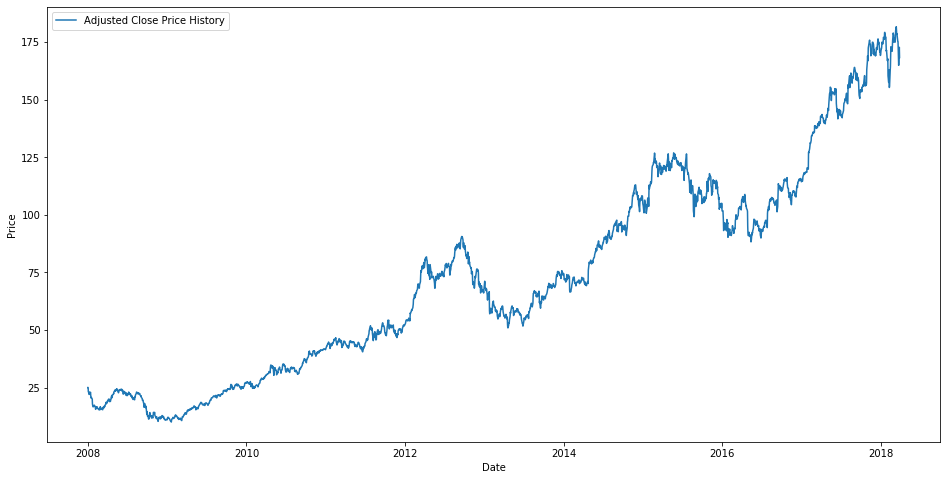

In [69]:
#Focus on a stock ticker that produce one of the highest R2 score
aapl_df = tdf.loc[tdf['ticker'] == 'AAPL']

#setting index as date
aapl_df['date'] = pd.to_datetime(aapl_df.date,format='%Y-%m-%d')
aapl_df.index = aapl_df['date']

plt.figure(figsize=(16,8))
plt.plot(aapl_df['adj_close'], label = 'Adjusted Close Price History')
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()

r2: 0.9995177141254861, MSE: 0.3805569548325651


C:\Users\beep9\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\beep9\anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\beep9\anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

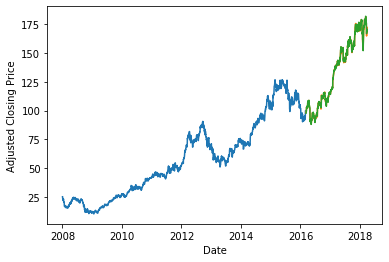

In [72]:
# Set index as date values
aapl_df['date'] = pd.to_datetime(aapl_df.date,format='%Y-%m-%d')
aapl_df.index = aapl_df['date']

# Sort the data
data = aapl_df.sort_index(ascending=True, axis=0)

# Create a new dataset. Select only needed columns
new_data = data.drop(['ticker','day_of_week_name'], axis=1)
#new_data.head()

train = new_data[:int(new_data.shape[0]*0.8)]
test = new_data[int(new_data.shape[0]*0.8):]

# Run model without data scaled
x_train = train.drop(['date','close','adj_close'], axis=1)
y_train = train['adj_close']
x_test = test.drop(['date','close','adj_close'], axis=1)
y_test = test['adj_close']


model = LinearRegression()
x_train.head()
model.fit(x_train,y_train)
preds = model.predict(x_test)
MSE = mean_squared_error(y_test, preds)
r2 = model.score(x_test, y_test)
# Graph to show predicted trend for adjusted closing price for year 2015 to 2018

test['Predictions'] = 0
#valid.head()
test['Predictions'] = preds
test.head()
plt.plot(train['adj_close'])
plt.plot(test[['adj_close', 'Predictions']])
plt.xlabel("Date")
plt.ylabel("Adjusted Closing Price")
print(f'r2: {r2}, MSE: {MSE}')

C:\Users\beep9\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


MSE:  8027.272, -17.731


C:\Users\beep9\anaconda3\lib\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\beep9\anaconda3\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


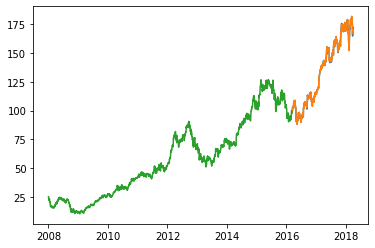

In [85]:
#trying KNN model

# Set index as date values
aapl_df['date'] = pd.to_datetime(aapl_df.date,format='%Y-%m-%d')
aapl_df.index = aapl_df['date']

# Sort the data
data = aapl_df.sort_index(ascending=True, axis=0)

# Create a new dataset. Select only needed columns
new_data = data.drop(['ticker','day_of_week_name'], axis=1)
#new_data.head()

train = new_data[:int(new_data.shape[0]*0.8)]
test = new_data[int(new_data.shape[0]*0.8):]

X_train = train.drop(['date','close','adj_close'], axis=1)
y_train = train['adj_close']
X_test = test.drop(['date','close','adj_close'], axis=1)
y_test = test['adj_close']


x_train_scaled = StandardScaler().fit_transform(x_train)
#x_train_scaled = scaler().fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)
x_test_scaled = StandardScaler().fit_transform(x_test)
x_test = pd.DataFrame(x_test_scaled)

#using gridsearch to find the best parameter
#https://www.analyticsvidhya.com/blog/2018/10/predicting-stock-price-machine-learningnd-deep-learning-techniques-python/?
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
knn = neighbors.KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)

#fit the model and make predictions
model.fit(x_train,y_train)
predictions = model.predict(x_test)

MSE = mean_squared_error(y_test, predictions)
r2 = model.score(X_test, y_test)

# Plot now scaled graph of the actual and predicted values
test['Predictions'] = 0
test['Predictions'] = preds
plt.plot(test[['adj_close', 'Predictions']])
plt.plot(train['adj_close'])
print(f"MSE: {MSE: .3f}, {r2: .3f}") 
